# Bill Management

The purpose of this notebook is use multimodality. In autogen v.0.4 there are NO MultimodalCoversableAgent class but the AssistantAgent [reference in documentation](https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/tutorial/agents.html#multi-modal-input). Nevertheless, the documentation only shows solo agents receiving multimodal messages to process (counting on the llm-client api supporting multimodality), meaning a single task definition. Trying to implement a team (Swarm of agents or a SelectorGroupChat) using multimodality proved to be challenging as shown in the section Swarm (Team's Multimodality in autogen v0.4).

For that reason, the agents are working independently joined by a simple logic inside a custom method with a unique user's input task with the target local images of bills. The agents could be add to a graph or used as AgentTools as part of a team. The implementation is kept the simplest though, keeping in mind that multimodality is what we care to try here.

### Config

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from autogen_ext.models.openai import OpenAIChatCompletionClient

openai_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

In [3]:
import json
from rich import print_json
from IPython.display import Markdown

def pretty_print(response_str:str):
    if isinstance(response_str, dict):
        print_json(json.dumps(response_str, indent=2))
    else:
        Markdown(response_str)

In [4]:
receipts_paths = [
    'receipt_1.png',
    'receipt_2.png',
    'receipt_3.png'
]

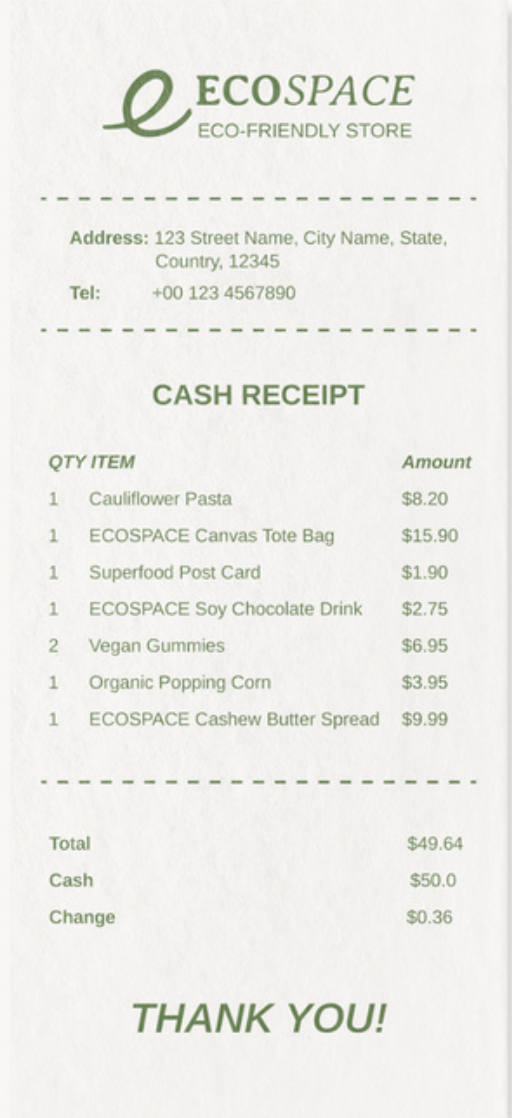

In [5]:
import PIL

PIL.Image.open("receipt_2.png")

### Agents

In [6]:
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from pydantic import BaseModel, Field
from typing import List, Dict, Optional


class BillItem(BaseModel):
    category: str
    item: str
    amount: int
    total: float


class BillStructure(BaseModel):
    source: str
    bill_category: str
    partition: List[BillItem]
    grand_total: Optional[float]
    metadata: Optional[str]

    model_config = {
        "json_schema_extra": {
            "required": ["source", "bill_category", "partition"]
        }
    }


user_proxy = UserProxyAgent("user_proxy", input_func=input) 

bill_manager_agent = AssistantAgent(
    "manager",
    model_client=openai_client,
    system_message="""
    You are the Manager Agent for a Bill Management System.

    Your responsibilities:
    - Greet the user and ask for tasks (specifically, the local file paths of bill images).

    Once you have all the paths the user where the user has the bills stored, output a markdow JSON structure response and end with DATA COLLECTED to close the task (ensure json properties are enclosed in double quotes):
    ```json
    {
        "paths": [<path_1>, <path_2>, <path_3>, ...]
    }
    ```
    DATA COLLECTED
    """,
)

bill_processing_agent = AssistantAgent(
    "image_processing_agent",
    model_client=openai_client,
    system_message="""You are the Bill Processing Agent.

    You receive image file paths of bills and receipts from the Manager Agent.
    
    Your job:
    - Extract itemized expenses from each image.
    - Categorize the expense_category into groups (e.g., groceries, dining, utilities, shopping, entertainment, etc.).
    - Return the categorized output back to the `manager` Agent in a clean, structured JSON format.

    The return JSON must 3 keys + 1 optional 'grand_total':
    - 'source': the clean image path str of the bill.
    - 'bill_category': global bill expense_category.
    - 'partition': parsed image content structured as a list of dictionaries (one per unique item) with a `category`, `item`, `amount`, and `total` keys.
    - 'grand_total': Some receipts have a Total amount  
    - 'metadata': Any extra information contained in the image of the bill. It should be a string formated as logical sentences telling coherent and relevant information found in the bill image that does not fit in any of the previous keys.

    Expected output JSON structure:

    {
        'source': <image path>
        'bill_category': <global bill expense category>,
        'partition': [
             {
                 'category': <item_1 expense_category>, 
                 'item': <item_1 name string>, 
                 'amount': <item_1 amount int>, 
                 'total': <item_1 total value float>
             }, 
             {
                 'category': <item_2 expense_category>, 
                 'item': <item_2 name string>, 
                 'amount': <item_2 amount int>, 
                 'total': <item_2 total value float>
             },
             ...
        ],
        'grand_total': <bill's total value if provided>
        'metadata': <any other parsed text that is not part of the other fields>
    }
    """,
    output_content_type=BillStructure,
)

expense_summarization_agent = AssistantAgent(
    "summarizer_agent",
    model_client=openai_client,
    system_message="""
    You are the Expense Summarization Agent.

    You receive a batch of categorized expenses from the Manager Agent.
    
    Your job:
    - Analyze all the categorized expenses.
    - Provide a clear breakdown of total spending per category. Mention the sources (file paths) and any relevant information in the process.
    - Highlight the highest spending categories and any unusual trends.
    - Always use tables in Markdown format for clear presentation when suitable.
    - Do not include mathematical formulas (calculations) in latex or anything similar. The report should be attractive and easy to read, yet detailed.
    - Your output is in Markdown format. Make sure that when you include dollar signs ($), you escape each dollar sign char as \\$ to prevent misinterpretation by parsers or template engines. For example, convert $12.99 to \\$12.99.
    
    Summarize the overall financial behavior in a user-friendly Markdown format.
    The summary should include a section in JSON (between triply backticks) with an aggregation of all the bills parsed (all the information  organized in a clear JSON structure).
    
    Do not request additional input — just generate the summary based on provided data.

    Revise that any containing dollar signs ($) are escaped as \\$ to prevent misinterpretation by parsers or template engines. For example, convert $12.99 to \\$12.99.
    Once finished, end your response with "TERMINATE".
    You must first send your message, then you can handoff to the `manager`.
    """,
)

In [7]:
import json

from rich import print_json
from rich import print as rprint
from IPython.display import Markdown


def pretty_print(response):
    if isinstance(response, dict):
        print_json(json.dumps(response, indent=2))
        return None
    elif isinstance(response, str):
        return Markdown(response)
    else:
        rprint(response)
        return None

In [8]:
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.conditions import TextMentionTermination, MaxMessageTermination

termination = TextMentionTermination("DATA COLLECTED") | MaxMessageTermination(10)
manager_team = RoundRobinGroupChat([bill_manager_agent , user_proxy], termination_condition=termination)

In [9]:
from json import JSONDecodeError

async def get_bill_paths():
    stream = manager_team.run_stream()
    conversation = []
    
    async for message in stream:
        if hasattr(message, "content"):
            if message.source == "manager":
                rprint(f"[red]🤖 {message.content}[/red]", end="")
            else:
                rprint(f"[blue]{message.content}[/blue]", end="")
                
            conversation.append(message.content)

    try:
        paths = json.loads(message.messages[-1].content.split("```")[-2].replace("json", "").strip())
        return paths
    except IndexError:
        return conversation
    except JSONDecodeError:
        last_message = message.messages[-1].content.split("```")[-2].replace("json", "").strip()
        json_message = json.loads(last_message.replace("'", '"'))
        return json_message

In [10]:
bills_paths = await get_bill_paths()

🤖 Hello! Welcome to the Bill Management System. Please provide me with the local file paths of your bill images, 
one at a time. When you're done, just let me know!

Enter your response:  "./receipt_2.png", "./receipt_4.png", "receipt_3.png"


"./receipt_2.png", "./receipt_4.png", "receipt_3.png"

🤖 Thank you for providing the paths. Here is the information collected:

```json
{
    "paths": ["./receipt_2.png", "./receipt_4.png", "receipt_3.png"]
}
```
DATA COLLECTED

In [11]:
pretty_print(bills_paths)

{
  "paths": [
    "./receipt_2.png",
    "./receipt_4.png",
    "receipt_3.png"
  ]
}

In [12]:
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image
from autogen_core import CancellationToken


async def parse_bills(paths):

    multimodal_messages = []
    for path in paths["paths"]:
        try:
            pil_image = PIL.Image.open(path)
            autogen_img = Image(pil_image)
            multimodal_messages.append(
                MultiModalMessage(content=[f"Parse this bill image: {path}.", autogen_img], source="user")
            )
        except FileNotFoundError:
            print(f"file: {path} not found on local path.")
            continue
    
    response_jsons = []
    for message in multimodal_messages:
        response = await bill_processing_agent.on_messages([message], CancellationToken())
        rprint(response)
        response_str = response.chat_message.to_text()
        response_jsons.append(json.loads(response_str))
        
    return response_jsons

In [13]:
parsed_structure = await parse_bills(bills_paths)

Response(
    chat_message=StructuredMessage[BillStructure](
        source='image_processing_agent',
        models_usage=RequestUsage(prompt_tokens=20428, completion_tokens=355),
        metadata={},
        content=BillStructure(
            source='./receipt_2.png',
            bill_category='shopping',
            partition=[
                BillItem(category='groceries', item='Cauliflower Pasta', amount=1, total=8.2),
                BillItem(category='shopping', item='ECOSPACE Canvas Tote Bag', amount=1, total=15.9),
                BillItem(category='stationery', item='Superfood Post Card', amount=1, total=1.9),
                BillItem(category='beverages', item='ECOSPACE Soy Chocolate Drink', amount=1, total=2.75),
                BillItem(category='snacks', item='Vegan Gummies', amount=2, total=6.95),
                BillItem(category='snacks', item='Organic Popping Corn', amount=1, total=3.95),
                BillItem(category='condiments', item='ECOSPACE Cashew Butter Spread', amount=1, total=9.99)
            ],
            grand_total=49.64,
            metadata='This receipt is from ECOSPACE, an eco-friendly store, with a total of $49.64. The payment was
made in cash of $50.00, with a change of $0.36.'
        ),
        format_string=None,
        type='StructuredMessage[BillStructure]'
    ),
    inner_messages=[]
)

Response(
    chat_message=StructuredMessage[BillStructure](
        source='image_processing_agent',
        models_usage=RequestUsage(prompt_tokens=34970, completion_tokens=312),
        metadata={},
        content=BillStructure(
            source='./receipt_4.png',
            bill_category='groceries',
            partition=[
                BillItem(category='beverages', item='Orange Juice', amount=1, total=2.15),
                BillItem(category='groceries', item='Apples', amount=1, total=3.5),
                BillItem(category='groceries', item='Tomato', amount=1, total=2.4),
                BillItem(category='seafood', item='Fish', amount=1, total=6.99),
                BillItem(category='meat', item='Beef', amount=1, total=10.0),
                BillItem(category='groceries', item='Onion', amount=1, total=1.25),
                BillItem(category='dairy', item='Cheese', amount=1, total=3.4)
            ],
            grand_total=29.69,
            metadata='This receipt is from a company without a specific name listed, totaling $29.69.'
        ),
        format_string=None,
        type='StructuredMessage[BillStructure]'
    ),
    inner_messages=[]
)

Response(
    chat_message=StructuredMessage[BillStructure](
        source='image_processing_agent',
        models_usage=RequestUsage(prompt_tokens=49468, completion_tokens=212),
        metadata={},
        content=BillStructure(
            source='receipt_3.png',
            bill_category='shopping',
            partition=[
                BillItem(category='clothing', item='T-Shirt', amount=1, total=25.5),
                BillItem(category='accessories', item='Watches', amount=1, total=299.0),
                BillItem(category='clothing', item='Pants', amount=1, total=32.99),
                BillItem(category='clothing', item='Socks', amount=1, total=6.5)
            ],
            grand_total=363.99,
            metadata='This receipt totals $363.99, with a cash payment of $400.00 and a change of $36.01.'
        ),
        format_string=None,
        type='StructuredMessage[BillStructure]'
    ),
    inner_messages=[]
)

In [14]:
print("🤖 bill_processing_agent:")
pretty_print(parsed_structure)

🤖 bill_processing_agent:


[
    {
        'source': './receipt_2.png',
        'bill_category': 'shopping',
        'partition': [
            {'category': 'groceries', 'item': 'Cauliflower Pasta', 'amount': 1, 'total': 8.2},
            {'category': 'shopping', 'item': 'ECOSPACE Canvas Tote Bag', 'amount': 1, 'total': 15.9},
            {'category': 'stationery', 'item': 'Superfood Post Card', 'amount': 1, 'total': 1.9},
            {'category': 'beverages', 'item': 'ECOSPACE Soy Chocolate Drink', 'amount': 1, 'total': 2.75},
            {'category': 'snacks', 'item': 'Vegan Gummies', 'amount': 2, 'total': 6.95},
            {'category': 'snacks', 'item': 'Organic Popping Corn', 'amount': 1, 'total': 3.95},
            {'category': 'condiments', 'item': 'ECOSPACE Cashew Butter Spread', 'amount': 1, 'total': 9.99}
        ],
        'grand_total': 49.64,
        'metadata': 'This receipt is from ECOSPACE, an eco-friendly store, with a total of $49.64. The payment was 
made in cash of $50.00, with a change of $0.36.'
    },
    {
        'source': './receipt_4.png',
        'bill_category': 'groceries',
        'partition': [
            {'category': 'beverages', 'item': 'Orange Juice', 'amount': 1, 'total': 2.15},
            {'category': 'groceries', 'item': 'Apples', 'amount': 1, 'total': 3.5},
            {'category': 'groceries', 'item': 'Tomato', 'amount': 1, 'total': 2.4},
            {'category': 'seafood', 'item': 'Fish', 'amount': 1, 'total': 6.99},
            {'category': 'meat', 'item': 'Beef', 'amount': 1, 'total': 10.0},
            {'category': 'groceries', 'item': 'Onion', 'amount': 1, 'total': 1.25},
            {'category': 'dairy', 'item': 'Cheese', 'amount': 1, 'total': 3.4}
        ],
        'grand_total': 29.69,
        'metadata': 'This receipt is from a company without a specific name listed, totaling $29.69.'
    },
    {
        'source': 'receipt_3.png',
        'bill_category': 'shopping',
        'partition': [
            {'category': 'clothing', 'item': 'T-Shirt', 'amount': 1, 'total': 25.5},
            {'category': 'accessories', 'item': 'Watches', 'amount': 1, 'total': 299.0},
            {'category': 'clothing', 'item': 'Pants', 'amount': 1, 'total': 32.99},
            {'category': 'clothing', 'item': 'Socks', 'amount': 1, 'total': 6.5}
        ],
        'grand_total': 363.99,
        'metadata': 'This receipt totals $363.99, with a cash payment of $400.00 and a change of $36.01.'
    }
]

In [15]:
from autogen_agentchat.messages import TextMessage

async def summarize_expenses(expenses):
    expenses_message = TextMessage(content=json.dumps(expenses, indent=2), source="user")
    response = await expense_summarization_agent.on_messages([expenses_message], CancellationToken())
    return response.chat_message.to_text()

In [16]:
summary_of_expenses = await summarize_expenses(parsed_structure)
print("🤖 expense_summarization_agent:")
pretty_print(summary_of_expenses)

🤖 expense_summarization_agent:


# Expense Summary Report

## Total Spending Breakdown by Category

| Category       | Total Amount (\$) | Source                  |
|----------------|-------------------|-------------------------|
| groceries      | \$15.00           | ./receipt_2.png        |
| shopping       | \$315.40          | receipt_3.png          |
| stationery     | \$1.90            | ./receipt_2.png        |
| beverages      | \$11.90           | ./receipt_2.png, ./receipt_4.png |
| snacks         | \$10.90           | ./receipt_2.png        |
| condiments     | \$9.99            | ./receipt_2.png        |
| seafood        | \$6.99            | ./receipt_4.png        |
| meat           | \$10.00           | ./receipt_4.png        |
| dairy          | \$3.40            | ./receipt_4.png        |
| clothing       | \$64.99           | receipt_3.png          |
| accessories     | \$299.00          | receipt_3.png          |

### Total Expenses Per Receipt

| Source            | Grand Total (\$) | Metadata                                                                                     |
|-------------------|------------------|----------------------------------------------------------------------------------------------|
| ./receipt_2.png   | \$49.64          | ECOSPACE, total \$49.64, cash payment of \$50.00, change \$0.36                           |
| ./receipt_4.png   | \$29.69          | Company without a specific name, total \$29.69                                            |
| receipt_3.png     | \$363.99         | Total \$363.99, cash payment of \$400.00, change \$36.01                                   |

## Highest Spending Categories 

- **Accessories**: \$299.00
- **Shopping** (includes clothing, etc.): \$315.40 
- **Groceries**: \$15.00

The most significant expenditures are found in accessories and shopping categories, indicating a possible one-time purchase or a trend in shopping behavior.

## Unusual Trends

- The clothing category includes a significant spending amount of \$64.99, yet it is part of a larger shopping expenditure totaling \$315.40.
- Snacks and beverages are consistent across the grocery shopping entries, although they make a lower contribution compared to shopping.

### Summary in JSON

```json
{
  "expenses": [
    {
      "source": "./receipt_2.png",
      "category": "shopping",
      "items": [
        {
          "category": "groceries",
          "item": "Cauliflower Pasta",
          "amount": 1,
          "total": 8.20
        },
        {
          "category": "shopping",
          "item": "ECOSPACE Canvas Tote Bag",
          "amount": 1,
          "total": 15.90
        },
        {
          "category": "stationery",
          "item": "Superfood Post Card",
          "amount": 1,
          "total": 1.90
        },
        {
          "category": "beverages",
          "item": "ECOSPACE Soy Chocolate Drink",
          "amount": 1,
          "total": 2.75
        },
        {
          "category": "snacks",
          "item": "Vegan Gummies",
          "amount": 2,
          "total": 6.95
        },
        {
          "category": "snacks",
          "item": "Organic Popping Corn",
          "amount": 1,
          "total": 3.95
        },
        {
          "category": "condiments",
          "item": "ECOSPACE Cashew Butter Spread",
          "amount": 1,
          "total": 9.99
        }
      ],
      "grand_total": 49.64,
      "metadata": "This receipt is from ECOSPACE, an eco-friendly store, with a total of $49.64. The payment was made in cash of $50.00, with a change of $0.36."
    },
    {
      "source": "./receipt_4.png",
      "category": "groceries",
      "items": [
        {
          "category": "beverages",
          "item": "Orange Juice",
          "amount": 1,
          "total": 2.15
        },
        {
          "category": "groceries",
          "item": "Apples",
          "amount": 1,
          "total": 3.50
        },
        {
          "category": "groceries",
          "item": "Tomato",
          "amount": 1,
          "total": 2.40
        },
        {
          "category": "seafood",
          "item": "Fish",
          "amount": 1,
          "total": 6.99
        },
        {
          "category": "meat",
          "item": "Beef",
          "amount": 1,
          "total": 10.00
        },
        {
          "category": "groceries",
          "item": "Onion",
          "amount": 1,
          "total": 1.25
        },
        {
          "category": "dairy",
          "item": "Cheese",
          "amount": 1,
          "total": 3.40
        }
      ],
      "grand_total": 29.69,
      "metadata": "This receipt is from a company without a specific name listed, totaling $29.69."
    },
    {
      "source": "receipt_3.png",
      "category": "shopping",
      "items": [
        {
          "category": "clothing",
          "item": "T-Shirt",
          "amount": 1,
          "total": 25.50
        },
        {
          "category": "accessories",
          "item": "Watches",
          "amount": 1,
          "total": 299.00
        },
        {
          "category": "clothing",
          "item": "Pants",
          "amount": 1,
          "total": 32.99
        },
        {
          "category": "clothing",
          "item": "Socks",
          "amount": 1,
          "total": 6.50
        }
      ],
      "grand_total": 363.99,
      "metadata": "This receipt totals $363.99, with a cash payment of $400.00 and a change of $36.01."
    }
  ]
}
```

Overall, the financial behavior indicates significant expenditures in the shopping and accessory categories, with a reasonable balance in groceries and related needs as well. 

TERMINATE

### Workflow

In [17]:
await manager_team.reset()

async def manage_bills():
    bills_paths = await get_bill_paths()
    parsed_structure = await parse_bills(bills_paths)
    summary_of_expenses = await summarize_expenses(parsed_structure)
    print("🤖 expense_summarization_agent:")
    display(pretty_print(summary_of_expenses))
    return summary_of_expenses

In [18]:
expenses_report = await manage_bills()

with open("expenses_report.md", "w") as report_file:
    report_file.write(expenses_report)

🤖 Hello! Welcome to the Bill Management System. Please provide the local file paths of the bill images you have 
stored. You can enter multiple paths, and I'll be able to process them.

Enter your response:  "./receipt_1.png", "./receipt_2.png", "receipt_3.png", "receipt_4.png"


"./receipt_1.png", "./receipt_2.png", "receipt_3.png", "receipt_4.png"

🤖 Thank you for providing the file paths. Here's the collected data in the requested format:

```json
{
    "paths": ["./receipt_1.png", "./receipt_2.png", "receipt_3.png", "receipt_4.png"]
}
```
DATA COLLECTED

Response(
    chat_message=StructuredMessage[BillStructure](
        source='image_processing_agent',
        models_usage=RequestUsage(prompt_tokens=75201, completion_tokens=257),
        metadata={},
        content=BillStructure(
            source='./receipt_1.png',
            bill_category='shopping',
            partition=[
                BillItem(category='groceries', item='Lorem', amount=1, total=1.1),
                BillItem(category='groceries', item='Ipsum', amount=1, total=2.2),
                BillItem(category='groceries', item='Dolor sit amet', amount=1, total=3.3),
                BillItem(category='groceries', item='Consectetur', amount=1, total=4.4),
                BillItem(category='groceries', item='Adipiscing elit', amount=1, total=5.5)
            ],
            grand_total=16.5,
            metadata='This receipt has a total amount of $16.50, with a cash payment of $20.00 and a change of 
$3.50.'
        ),
        format_string=None,
        type='StructuredMessage[BillStructure]'
    ),
    inner_messages=[]
)

Response(
    chat_message=StructuredMessage[BillStructure](
        source='image_processing_agent',
        models_usage=RequestUsage(prompt_tokens=95312, completion_tokens=355),
        metadata={},
        content=BillStructure(
            source='./receipt_2.png',
            bill_category='shopping',
            partition=[
                BillItem(category='groceries', item='Cauliflower Pasta', amount=1, total=8.2),
                BillItem(category='shopping', item='ECOSPACE Canvas Tote Bag', amount=1, total=15.9),
                BillItem(category='stationery', item='Superfood Post Card', amount=1, total=1.9),
                BillItem(category='beverages', item='ECOSPACE Soy Chocolate Drink', amount=1, total=2.75),
                BillItem(category='snacks', item='Vegan Gummies', amount=2, total=6.95),
                BillItem(category='snacks', item='Organic Popping Corn', amount=1, total=3.95),
                BillItem(category='condiments', item='ECOSPACE Cashew Butter Spread', amount=1, total=9.99)
            ],
            grand_total=49.64,
            metadata='This receipt is from ECOSPACE, an eco-friendly store, with a total of $49.64. The payment was
made in cash of $50.00, with a change of $0.36.'
        ),
        format_string=None,
        type='StructuredMessage[BillStructure]'
    ),
    inner_messages=[]
)

Response(
    chat_message=StructuredMessage[BillStructure](
        source='image_processing_agent',
        models_usage=RequestUsage(prompt_tokens=109853, completion_tokens=216),
        metadata={},
        content=BillStructure(
            source='receipt_3.png',
            bill_category='shopping',
            partition=[
                BillItem(category='clothing', item='T-Shirt', amount=1, total=25.5),
                BillItem(category='accessories', item='Watches', amount=1, total=299.0),
                BillItem(category='clothing', item='Pants', amount=1, total=32.99),
                BillItem(category='clothing', item='Socks', amount=1, total=6.5)
            ],
            grand_total=363.99,
            metadata='This receipt shows a total amount of $363.99, paid in cash of $400.00, with a change of 
$36.01.'
        ),
        format_string=None,
        type='StructuredMessage[BillStructure]'
    ),
    inner_messages=[]
)

Response(
    chat_message=StructuredMessage[BillStructure](
        source='image_processing_agent',
        models_usage=RequestUsage(prompt_tokens=124255, completion_tokens=309),
        metadata={},
        content=BillStructure(
            source='receipt_4.png',
            bill_category='groceries',
            partition=[
                BillItem(category='beverages', item='Orange Juice', amount=1, total=2.15),
                BillItem(category='groceries', item='Apples', amount=1, total=3.5),
                BillItem(category='groceries', item='Tomato', amount=1, total=2.4),
                BillItem(category='seafood', item='Fish', amount=1, total=6.99),
                BillItem(category='meat', item='Beef', amount=1, total=10.0),
                BillItem(category='groceries', item='Onion', amount=1, total=1.25),
                BillItem(category='dairy', item='Cheese', amount=1, total=3.4)
            ],
            grand_total=29.69,
            metadata='This receipt is from a company listing a total of $29.69.'
        ),
        format_string=None,
        type='StructuredMessage[BillStructure]'
    ),
    inner_messages=[]
)

🤖 expense_summarization_agent:


# Expense Summary Report

## Total Spending Breakdown by Category

| Category       | Total Amount (\$) | Source                  |
|----------------|-------------------|-------------------------|
| groceries      | \$22.00           | ./receipt_1.png, ./receipt_4.png |
| shopping       | \$346.49          | ./receipt_2.png, receipt_3.png |
| stationery     | \$1.90            | ./receipt_2.png        |
| beverages      | \$11.65           | ./receipt_2.png, ./receipt_4.png |
| snacks         | \$10.90           | ./receipt_2.png        |
| condiments     | \$9.99            | ./receipt_2.png        |
| seafood        | \$6.99            | ./receipt_4.png        |
| meat           | \$10.00           | ./receipt_4.png        |
| dairy          | \$3.40            | ./receipt_4.png        |
| clothing       | \$64.99           | receipt_3.png          |
| accessories    | \$299.00          | receipt_3.png          |

### Total Expenses Per Receipt

| Source            | Grand Total (\$) | Metadata                                                                                     |
|-------------------|------------------|----------------------------------------------------------------------------------------------|
| ./receipt_1.png   | \$16.50          | Total amount \$16.50, cash payment of \$20.00, change \$3.50                                                               |
| ./receipt_2.png   | \$49.64          | ECOSPACE, total \$49.64, cash payment of \$50.00, change \$0.36                           |
| receipt_3.png     | \$363.99         | Total amount \$363.99, cash payment of \$400.00, change \$36.01                          |
| ./receipt_4.png   | \$29.69          | Company listing, total \$29.69                                                                |

## Highest Spending Categories

- **Accessories**: \$299.00
- **Shopping**: \$346.49 
- **Clothing**: \$64.99

The highest expenditures are predominantly in the accessories and shopping categories, which could hint at specific trends in consumer behavior.

## Unusual Trends

- The clothing category's total of \$64.99 underscores a substantial investment, particularly when compared to the more modest amounts spent on groceries.
- Snacks and beverages remain consistent across various receipts; however, they continue to be overshadowed by larger purchases in the shopping and accessories segments.

### Summary in JSON

```json
{
  "expenses": [
    {
      "source": "./receipt_1.png",
      "category": "shopping",
      "items": [
        {
          "category": "groceries",
          "item": "Lorem",
          "amount": 1,
          "total": 1.10
        },
        {
          "category": "groceries",
          "item": "Ipsum",
          "amount": 1,
          "total": 2.20
        },
        {
          "category": "groceries",
          "item": "Dolor sit amet",
          "amount": 1,
          "total": 3.30
        },
        {
          "category": "groceries",
          "item": "Consectetur",
          "amount": 1,
          "total": 4.40
        },
        {
          "category": "groceries",
          "item": "Adipiscing elit",
          "amount": 1,
          "total": 5.50
        }
      ],
      "grand_total": 16.50,
      "metadata": "This receipt has a total amount of $16.50, with a cash payment of $20.00 and a change of $3.50."
    },
    {
      "source": "./receipt_2.png",
      "category": "shopping",
      "items": [
        {
          "category": "groceries",
          "item": "Cauliflower Pasta",
          "amount": 1,
          "total": 8.20
        },
        {
          "category": "shopping",
          "item": "ECOSPACE Canvas Tote Bag",
          "amount": 1,
          "total": 15.90
        },
        {
          "category": "stationery",
          "item": "Superfood Post Card",
          "amount": 1,
          "total": 1.90
        },
        {
          "category": "beverages",
          "item": "ECOSPACE Soy Chocolate Drink",
          "amount": 1,
          "total": 2.75
        },
        {
          "category": "snacks",
          "item": "Vegan Gummies",
          "amount": 2,
          "total": 6.95
        },
        {
          "category": "snacks",
          "item": "Organic Popping Corn",
          "amount": 1,
          "total": 3.95
        },
        {
          "category": "condiments",
          "item": "ECOSPACE Cashew Butter Spread",
          "amount": 1,
          "total": 9.99
        }
      ],
      "grand_total": 49.64,
      "metadata": "This receipt is from ECOSPACE, an eco-friendly store, with a total of $49.64. The payment was made in cash of $50.00, with a change of $0.36."
    },
    {
      "source": "receipt_3.png",
      "category": "shopping",
      "items": [
        {
          "category": "clothing",
          "item": "T-Shirt",
          "amount": 1,
          "total": 25.50
        },
        {
          "category": "accessories",
          "item": "Watches",
          "amount": 1,
          "total": 299.00
        },
        {
          "category": "clothing",
          "item": "Pants",
          "amount": 1,
          "total": 32.99
        },
        {
          "category": "clothing",
          "item": "Socks",
          "amount": 1,
          "total": 6.50
        }
      ],
      "grand_total": 363.99,
      "metadata": "This receipt shows a total amount of $363.99, paid in cash of $400.00, with a change of $36.01."
    },
    {
      "source": "receipt_4.png",
      "category": "groceries",
      "items": [
        {
          "category": "beverages",
          "item": "Orange Juice",
          "amount": 1,
          "total": 2.15
        },
        {
          "category": "groceries",
          "item": "Apples",
          "amount": 1,
          "total": 3.50
        },
        {
          "category": "groceries",
          "item": "Tomato",
          "amount": 1,
          "total": 2.40
        },
        {
          "category": "seafood",
          "item": "Fish",
          "amount": 1,
          "total": 6.99
        },
        {
          "category": "meat",
          "item": "Beef",
          "amount": 1,
          "total": 10.00
        },
        {
          "category": "groceries",
          "item": "Onion",
          "amount": 1,
          "total": 1.25
        },
        {
          "category": "dairy",
          "item": "Cheese",
          "amount": 1,
          "total": 3.40
        }
      ],
      "grand_total": 29.69,
      "metadata": "This receipt is from a company listing a total of $29.69."
    }
  ]
}
```

Overall, the financial behavior reflects significant investments in the shopping category, particularly through clothing and accessories, while groceries and basic items also maintain a regular expenditure pattern.

TERMINATE

### [DEV] Swarm (Run team with Multimodality in autogen v0.4)

There is not good documentation or support for multimodality in v0.4. Solutions must be done custom a with more complexity as in the course content (v0.2). 


The following are two failed attempts of doing multimodality with swarm of AssistantAgents [MultimodalConversableAgents are deprecated in v0.4](https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/migration-guide.html#multi-modal-agent).

In [19]:
raise Exception("THE CODE ABOVE SHOULD NOT BE EXECUTED (This exception's purpose is to stop end2end execution at this point")

Exception: THE CODE ABOVE SHOULD NOT BE EXECUTED (This exception's purpose is to stop end2end execution at this point

In [ ]:
from autogen_agentchat.agents import AssistantAgent


bill_manager_agent = AssistantAgent(
    "manager",
    model_client=openai_client,
    handoffs=["image_processing_agent", "summarizer", "user"],
    system_message="""
    You are the Manager Agent for a Bill Management System.

    Your responsibilities:
    - Greet the user and ask for tasks (specifically, the local file paths of bill images).
    - For each valid image path received, hand off the task to the `image_processing_agent`.
    - Keep track of processed files.
    
    After processing:
    - Ask the user for more bills to process.
    - If the user indicates there are no more bills, hand off to the `summarizer_agent`.
    - You may also decide to TERMINATE the conversation if everything is complete. For that just respond with "TERMINATE" as your last string.

    You must only hand-off to ONE of ["image_processing_agent", "summarizer", "user"] each time.
    
    Always keep the conversation orderly, prompt-driven, and focused.
    If you need information from the user, you must first send your message, then you can handoff to the user.
    """,
)

bill_processing_agent = AssistantAgent(
    "image_processing_agent",
    model_client=openai_client,
    handoffs=["manager"],
    system_message="""You are the Bill Processing Agent.

    You receive image file paths of bills and receipts from the Manager Agent.
    
    Your job:
    - Extract itemized expenses from each image.
    - Categorize expenses into groups (e.g., groceries, dining, utilities, etc.).
    - Return the categorized output back to the `manager` Agent in a clean, structured format.
    
    Do not ask the user anything directly.
    If the input is a valid image path, process it. If not, respond with NOT VALID.
    You must first send your message, then you can handoff to the `manager`.
    """,
)

expense_summarization = AssistantAgent(
    "summarizer_agent",
    model_client=openai_client,
    handoffs=["manager"],
    system_message="""
    You are the Expense Summarization Agent.

    You receive a batch of categorized expenses from the Manager Agent.
    
    Your job:
    - Analyze all the categorized expenses.
    - Provide a clear breakdown of total spending per category.
    - Highlight the highest spending categories and any unusual trends.
    
    Summarize the overall financial behavior in a user-friendly format.
    
    Do not request additional input — just generate the summary based on provided data.
    Once finished, end your response with "TERMINATE".
    You must first send your message, then you can handoff to the `manager`.
    """,
)

In [ ]:
from autogen_agentchat.conditions import HandoffTermination, TextMentionTermination
from autogen_agentchat.teams import Swarm


termination = HandoffTermination(target="user") | TextMentionTermination("TERMINATE")
team = Swarm([bill_manager_agent, bill_processing_agent, expense_summarization], termination_condition=termination)

In [ ]:
from autogen_agentchat.messages import MultiModalMessage
from rich import print as rprint

initial_task = [
    MultiModalMessage(source="user", modality="image", content=["./receipt_1.png"])
]

conversation = []
async for message in team.run_stream(task=initial_task):
    if hasattr(message, "content"):
        rprint(f"[red]🤖 [{message.source}, {message.type}] {message.content}[/red]", end="") 
        conversation.append(message.content)
    else:
        print(message)

In [ ]:
from rich import print as rprint

async def bill_management_team(task=None, verbose=False):
    if not task:
        stream = team.run_stream()
    else:
        stream = team.run_stream(task=task)
    conversation = []
    
    async for message in stream:
        if hasattr(message, "content"):
            rprint(f"[red]🤖 [{message.source}, {message.type}] {message.content}[/red]", end="") 
            conversation.append(message.content)
                
        elif verbose: # prints conversation TaskResult (last message)
            print("TaskResult:")
            rprint(message)
    
    return message, conversation

In [ ]:
from autogen_agentchat.messages import HandoffMessage
from autogen_agentchat.messages import MultiModalMessage
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken, Image
from pathlib import Path


async def run_team_stream() -> None:
    task_result, conversation = await bill_management_team()
    last_message = task_result.messages[-1]
    print("\nlast_message (task_result): ", last_message)
    
    if isinstance(last_message, HandoffMessage):
         rprint(f"[blue] [OUT] {last_message.target} [/blue]", end="")
         if last_message.target == "image_processing_agent":
                rprint(f"[green] [OUT] {last_message} [/green]", end="")
        
    if isinstance(last_message, HandoffMessage) and last_message.target == "user":
        user_message = input("User: ")
        multimodal_user_message = MultiModalMessage(
            content=["Here is a bill:", Image.from_file(Path(user_message))],
            source="user",
        )
        bill_content = await bill_processing_agent.on_messages([multimodal_user_message], CancellationToken())
        task_result_in, conversation_in = await bill_management_team(task=HandoffMessage(source="user", target=last_message.source, content=f"{user_message}: {bill_content}"), verbose=False)
        
        #message = MultiModalMessage(
        #content=["Here is an image:", Image.from_file(Path("test.png"))],
        #source="user",
        #)
        last_message_in = task_result_in.messages[-1]
        print("\nlast_message_in (task_result_in): ", last_message_in)
    
        if isinstance(last_message_in, HandoffMessage):
            rprint(f"[blue] [IN] {last_message_in.target} [/blue]", end="")
            if last_message_in.target == "image_processing_agent":
                rprint(f"[green] [IN] {last_message_in} [/green]", end="")
        

In [ ]:
await run_team_stream()